This notebook aims to demonstrate the work flow of a typical DA project.

Because we already have sufficient labels and data, so we directly come to data cleaning.

Then we do EDA (Exploratory Data Analysis)

Then come to Feature Engineering

Then try different machine learning models with model evaluation

### Part 1 Data Cleaning

In [1]:
# All packages possibly used
#These are for data cleaning and EDA
import pandas as pd
import numpy as np
import math
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action = 'ignore', category = UserWarning)
from sklearn.metrics import accuracy_score
#Packages for building models
#two scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

In [2]:
sns.set(rc = {'figure.figsize':{12,8}})
from sklearn.model_selection import train_test_split

In [3]:
#Read the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
df_combined = pd.concat([train, test])
df_combined
#pd.concat: 上下拼接，需要中括号

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


Test does not have the "survived" column.

In [7]:
#numerical and categorical columns
num_cols = df_combined.select_dtypes(exclude = 'object').columns
cat_cols = df_combined.select_dtypes(include = 'object').columns
print('numerical: ', num_cols)
print('categorical: ', cat_cols)

numerical:  Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')
categorical:  Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')


In [8]:
for col in cat_cols:
    print("%s has %d unique values" % (col, df_combined[col].nunique()))

Name has 1307 unique values
Sex has 2 unique values
Ticket has 929 unique values
Cabin has 186 unique values
Embarked has 3 unique values


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [11]:
# get the number of null values
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [13]:
#Drop column 'cabin' because the percentage of missing value is high
df_combined = df_combined.drop(['Cabin'], axis = 1)
#axis = 1 means dropping columns
df_combined['Age_Class'] = round(df_combined['Age']/20 + 0.5)
df_combined['Fare_Class'] = round(df_combined['Fare']/100 + 0.5)

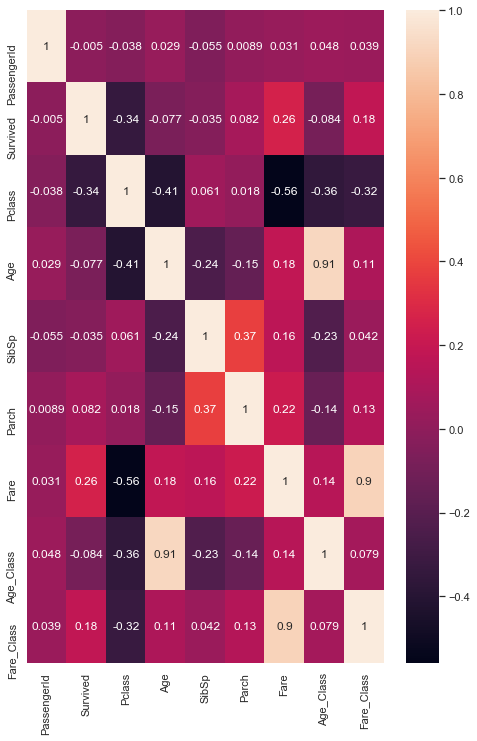

In [14]:
sns.heatmap(df_combined.corr(), annot = True)

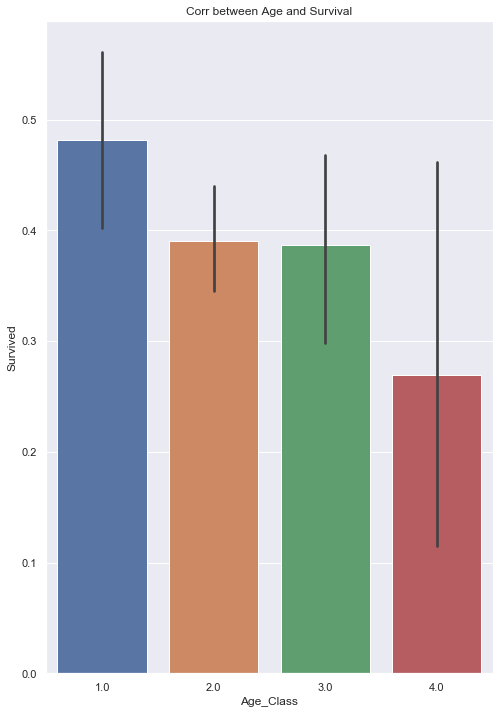

In [15]:
sns.barplot(data = df_combined, x = 'Age_Class', y = 'Survived')
plt.title('Corr between Age and Survival')
plt.show()

In [16]:
df_combined['relatives'] = df_combined['Parch'] + df_combined['SibSp']

In [17]:
df_combined['Age'] = df_combined['Age'].fillna(method = 'ffill')

In [18]:
df_combined['Age_Class'] = round(df_combined['Age']/20 + 0.5)

In [19]:
df_combined['Sex'] = [1 if x == 'male' else 0 for x in df_combined['Sex']]

In [20]:
df_combined['Embarked'] = df_combined['Embarked'].fillna(method = 'ffill')
df_combined['Fare'] = df_combined['Fare'].fillna(method = 'ffill')
df_combined['Fare_Class'] = round(df_combined['Fare']/100 + 0.5)


In [21]:
df_combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_Class,Fare_Class,relatives
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,2.0,1.0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,2.0,1.0,1
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,2.0,1.0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2.0,1.0,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",1,28.0,0,0,A.5. 3236,8.0500,S,2.0,1.0,0
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C,2.0,2.0,0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,2.0,1.0,0
416,1308,NaN,3,"Ware, Mr. Frederick",1,38.5,0,0,359309,8.0500,S,2.0,1.0,0


In [22]:
df_combined['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

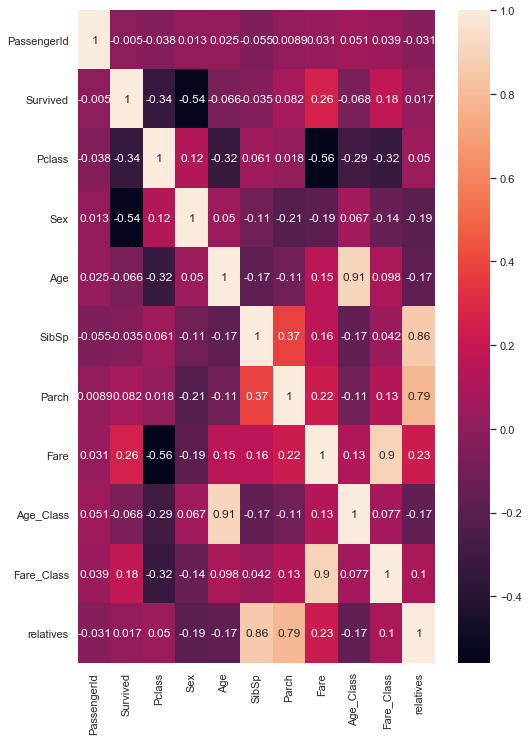

In [23]:
sns.heatmap(df_combined.corr(), annot = True)

In [24]:
df_combined = df_combined.set_index('PassengerId')
df_train = df_combined.dropna(subset = ['Survived'])
df_test = df_combined.drop(df_train.index)

In [25]:
df_train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_Class,Fare_Class,relatives
PassengerId,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S,2.0,1.0,1
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C,2.0,1.0,1
3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S,2.0,1.0,0
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S,2.0,1.0,1
5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S,2.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,S,2.0,1.0,0
888,1.0,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,S,1.0,1.0,0
889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,19.0,1,2,W./C. 6607,23.4500,S,1.0,1.0,3


### Make GBM

In [26]:
#get the columns we need
data = [c for c in df_train.columns if c not in ['Survived', 'Name','Embarked','Ticket']]
X = df_train[data]
y = df_train['Survived']
df_test = df_test[data]

In [27]:
#Grid Search Parameters
params = {'boosting_type':['gbdt'],'learning_rate':[0.8,0.5,0.3,0.1,0.01],
         'max_depth':[1,3,5,7,9,12,15],
         'n_estimators':[100,300,500,700,1000,1500],
         'num_leaves':[20,35,50,75,100,150,300,500],
         'random_state':[42]}
model = lgb.LGBMClassifier()


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [29]:
gscv = GridSearchCV(model, params, cv = 5, n_jobs = -1, verbose = True)

In [30]:
gscv.fit(X_train, y_train, eval_set = (X_test, y_test), early_stopping_rounds = 50, verbose = False)


Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 7600 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 8400 out of 8400 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent='wa...
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [

In [90]:
gscv.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 15,
 'n_estimators': 500,
 'num_leaves': 20,
 'random_state': 42}

In [91]:
gscv.best_score_

0.8323532712377959

In [31]:
gscv = gscv.best_estimator_

In [32]:
gscv.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=20, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [33]:
y_preds = gscv.predict(X_train)
t_preds = gscv.predict(X_test)
print('train accuracy: ', accuracy_score(y_preds, y_train))
print('Test accuracy: ', accuracy_score(t_preds, y_test))

train accuracy:  0.907185628742515
Test accuracy:  0.8385650224215246


In [38]:
pred_train = gscv.predict(X_train, pred_leaf = True)
pred_test = gscv.predict(X_test, pred_leaf = True)
num_leaves = gscv.num_leaves

In [41]:
def form_onehot(int_df):
    output_df = []
    for i in int_df:
        row_l = []
        for j in i:
            temp_l = np.zeros(num_leaves)
            temp_l[j] = 1
            row_l.extend(temp_l)
        output_df.append(row_l)
    return output_df 

In [43]:
stack_train = form_onehot(pred_train)
stack_test = form_onehot(pred_test)

In [44]:
gbdt_lr = LogisticRegression(penalty='l1', random_state=42).fit(stack_train, y_train)
gbdt_lr_pred = gbdt_lr.predict(stack_test)
print("GBDT-LR ROCAUC score: {:.2f}".format(roc_auc_score(y_test, gbdt_lr_pred)))

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [103]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': preds})

In [105]:
submission['Survived'] = submission['Survived'].astype('Int64')

In [108]:
submission.to_csv('submission.csv',index = False)

In [107]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
